In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


In [3]:
data = pd.read_csv('creditcard.csv', sep = ',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    7973 non-null   int64  
 1   V1      7973 non-null   float64
 2   V2      7973 non-null   float64
 3   V3      7973 non-null   float64
 4   V4      7973 non-null   float64
 5   V5      7973 non-null   float64
 6   V6      7973 non-null   float64
 7   V7      7973 non-null   float64
 8   V8      7973 non-null   float64
 9   V9      7973 non-null   float64
 10  V10     7973 non-null   float64
 11  V11     7973 non-null   float64
 12  V12     7973 non-null   float64
 13  V13     7973 non-null   float64
 14  V14     7973 non-null   float64
 15  V15     7972 non-null   float64
 16  V16     7972 non-null   float64
 17  V17     7972 non-null   float64
 18  V18     7972 non-null   float64
 19  V19     7972 non-null   float64
 20  V20     7972 non-null   float64
 21  V21     7972 non-null   float64
 22  

***EXPLORATORY DATA ANALYSIS***

In [5]:
data.isnull().values.any()

True

In [6]:
data.dropna(inplace=True)

In [7]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

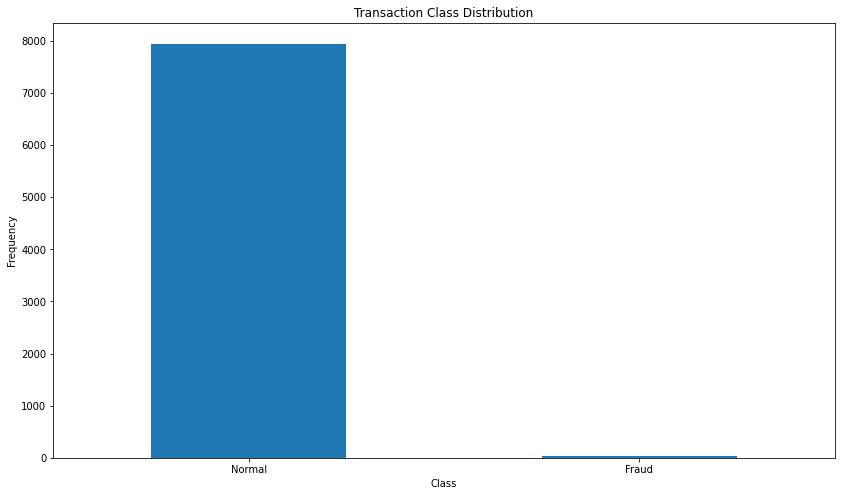

In [8]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('Transaction Class Distribution')
plt.xticks(range(2), LABELS)
plt.xlabel('Class')
plt.ylabel('Frequency')

In [9]:
## Get the Fraud and the normal dataset 

fraud = data[data['Class'] == 1]
normal = data[data['Class'] == 0]

In [10]:
print(fraud.shape, normal.shape)

(25, 31) (7947, 31)


In [11]:
fraud.Amount.describe()

count      25.000000
mean      106.308400
std       372.676883
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1809.680000
Name: Amount, dtype: float64

In [12]:
normal.Amount.describe()

count    7947.000000
mean       65.284891
std       194.126547
min         0.000000
25%         4.795000
50%        15.950000
75%        54.990000
max      7712.430000
Name: Amount, dtype: float64

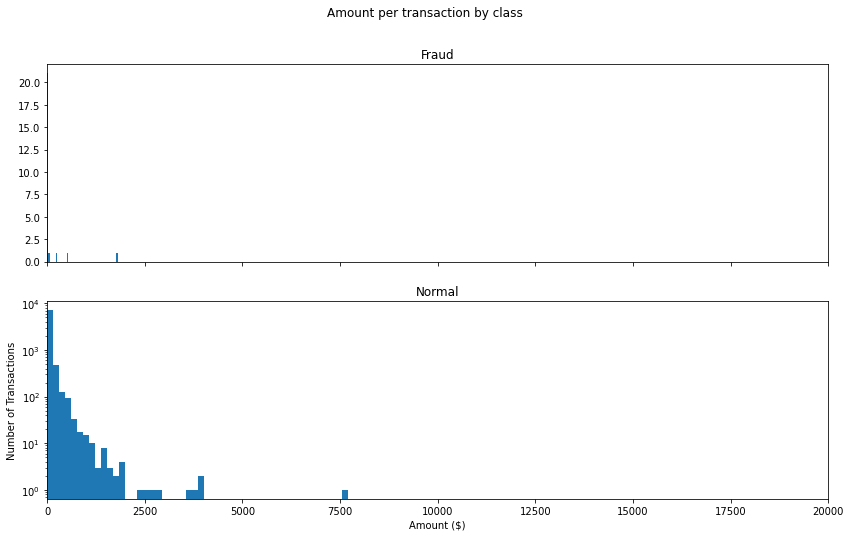

In [13]:
fg, (ax1, ax2) = plt.subplots(2,1, sharex = True)
fg.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

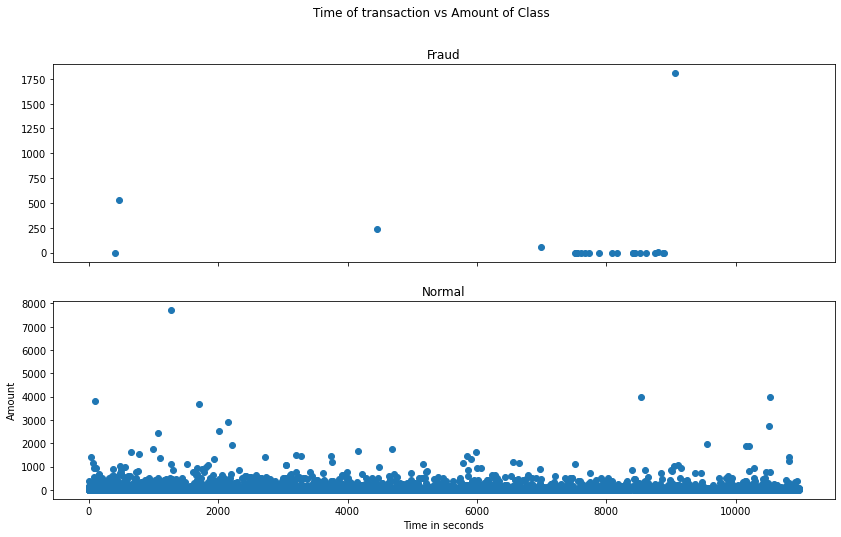

In [14]:
# Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.
f, (ax1,ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Time of transaction vs Amount of Class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time in seconds')
plt.ylabel('Amount')
plt.show()


In [15]:
data1 = data.sample(frac=0.1, random_state=1)

In [16]:
data1.shape

(797, 31)

In [18]:
fraud = data1[data1["Class"] == 1]
valid = data1[data1["Class"] == 0]
fraud.shape

(1, 31)

In [19]:
outlier_fraction = len(fraud)/float(len(valid))


In [20]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(fraud)))

print("Valid Cases : {}".format(len(valid)))

0.001256281407035176
Fraud Cases : 1
Valid Cases : 796


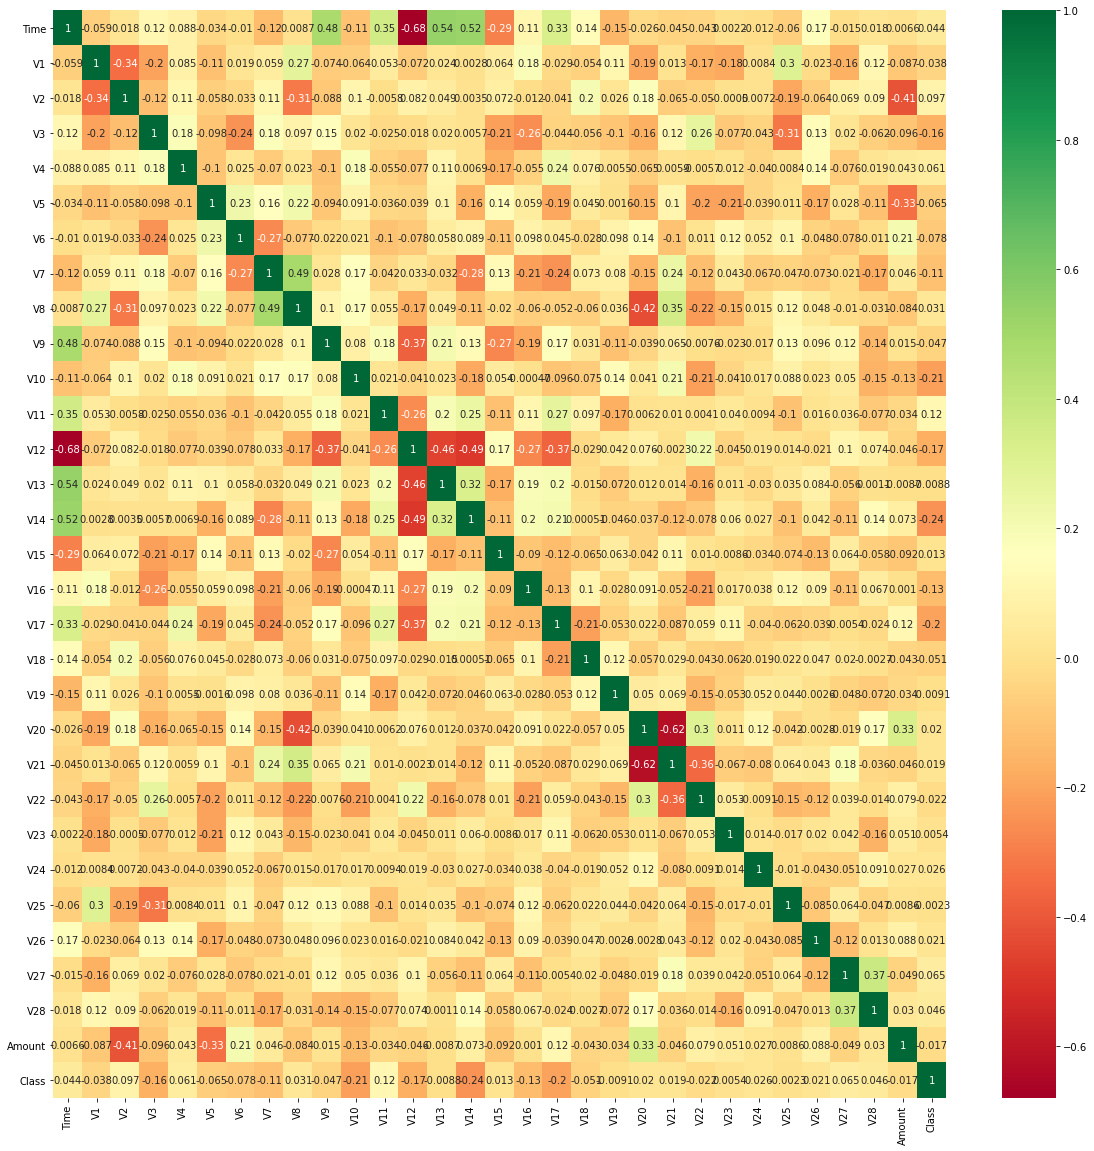

In [22]:
##Correlation
import seaborn as sns
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#Heatmap
g = sns.heatmap(data1[top_corr_features].corr(), annot = True, cmap = 'RdYlGn')

In [23]:
columns = data1.columns.to_list()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low = 0, high = 1, size = (X.shape[0], X.shape[1]))

In [24]:
print(X.shape)

(797, 30)


In [25]:
print(Y.shape)

(797,)


MODEL

In [32]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [33]:
type(classifiers)

dict

In [37]:
n_outliers = len(fraud)
for i, (clf_name, clf) in enumerate(classifiers.items()):
  if clf_name == "Local Outlier Factor":
    y_pred = clf.fit_predict(X)
    scores_prediction = clf.negative_outlier_factor_
  elif clf_name == "Support Vector Machine":
    clf.fit(X)
    y_pred = clf.predict(X)
  else:
    clf.fit(X)
    scores_prediction = clf.decision_function(X)
    y_pred = clf.predict(X)
  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1
  n_errors = (y_pred != Y).sum()
  #Run Classification Metrics
  print("{}: {}".format(clf_name, n_errors))
  print("Accuracy Score: ")
  print(accuracy_score(Y, y_pred))
  print("Classification Report: ")
  print(classification_report(Y, y_pred))

Isolation Forest: 2
Accuracy Score: 
0.9974905897114178
Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       796
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00       797
   macro avg       0.50      0.50      0.50       797
weighted avg       1.00      1.00      1.00       797

Local Outlier Factor: 2
Accuracy Score: 
0.9974905897114178
Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       796
         1.0       0.00      0.00      0.00         1

    accuracy                           1.00       797
   macro avg       0.50      0.50      0.50       797
weighted avg       1.00      1.00      1.00       797

Support Vector Machine: 377
Accuracy Score: 
0.5269761606022585
Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.53      